In [300]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import optuna
import shap

In [301]:
DATA_PATH = './Data/'

TRAIN_DATA_PATH = DATA_PATH + 'train.csv'
TEST_DATA_PATH = DATA_PATH + 'test.csv'
SUBMISSION_DATA_PATH = DATA_PATH + 'sample_submission.csv'

In [302]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
submission_df = pd.read_csv(SUBMISSION_DATA_PATH)

train_df.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


In [303]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [304]:
def show_graph(col):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x=train_df[f'{col}'].value_counts().index, 
                y=train_df[f'{col}'].value_counts().values, 
                palette='Set3', 
                ax=ax)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



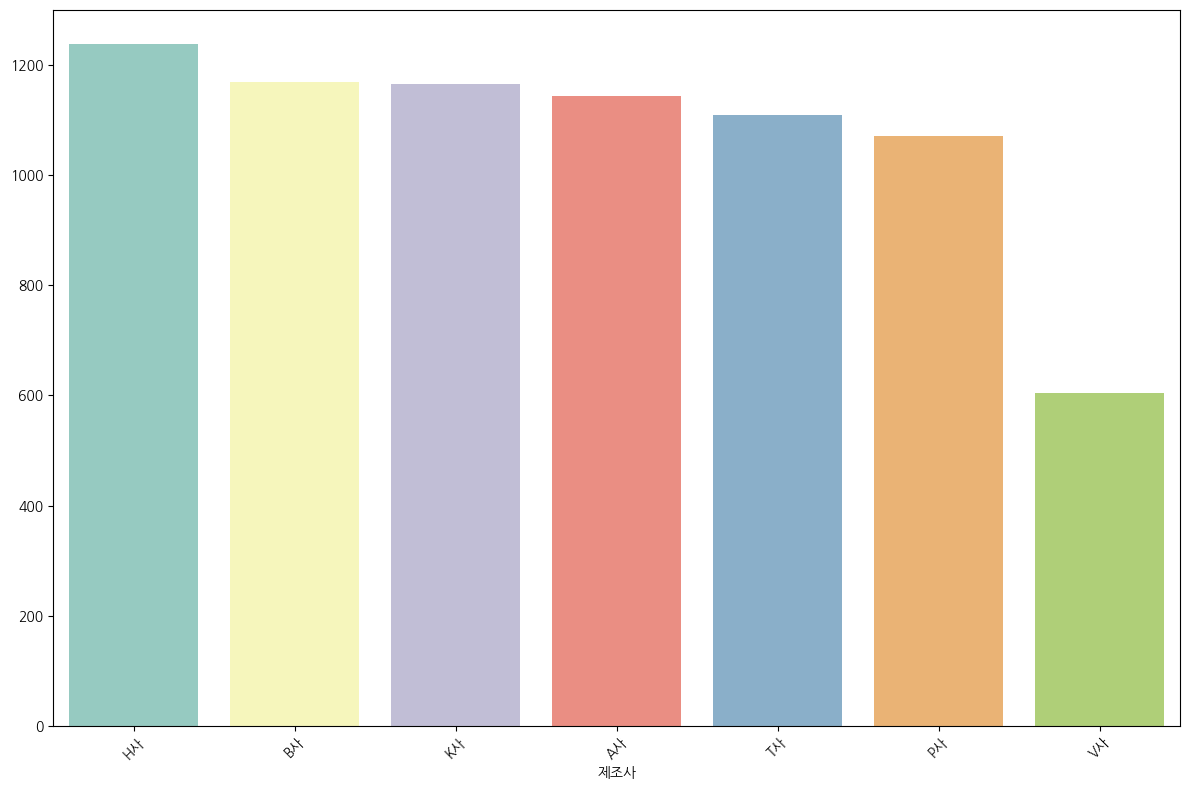

In [305]:
show_graph('제조사')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



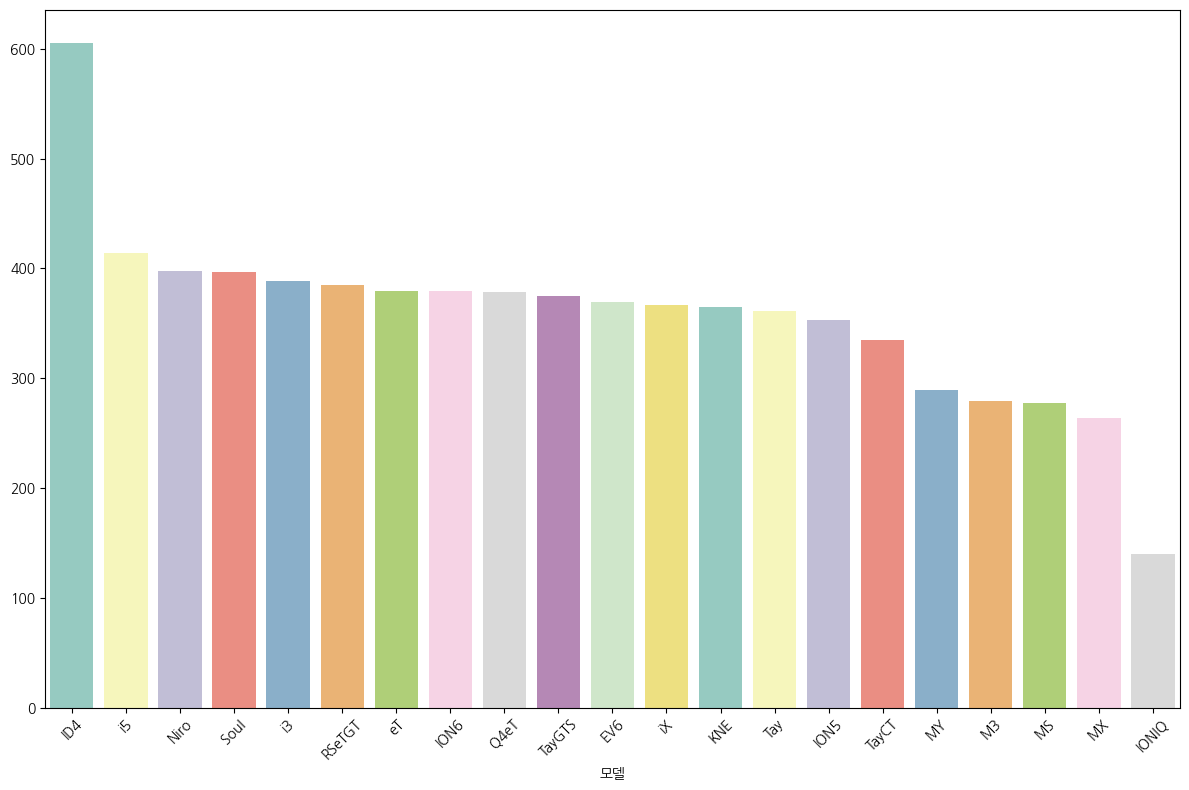

In [306]:
show_graph('모델')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



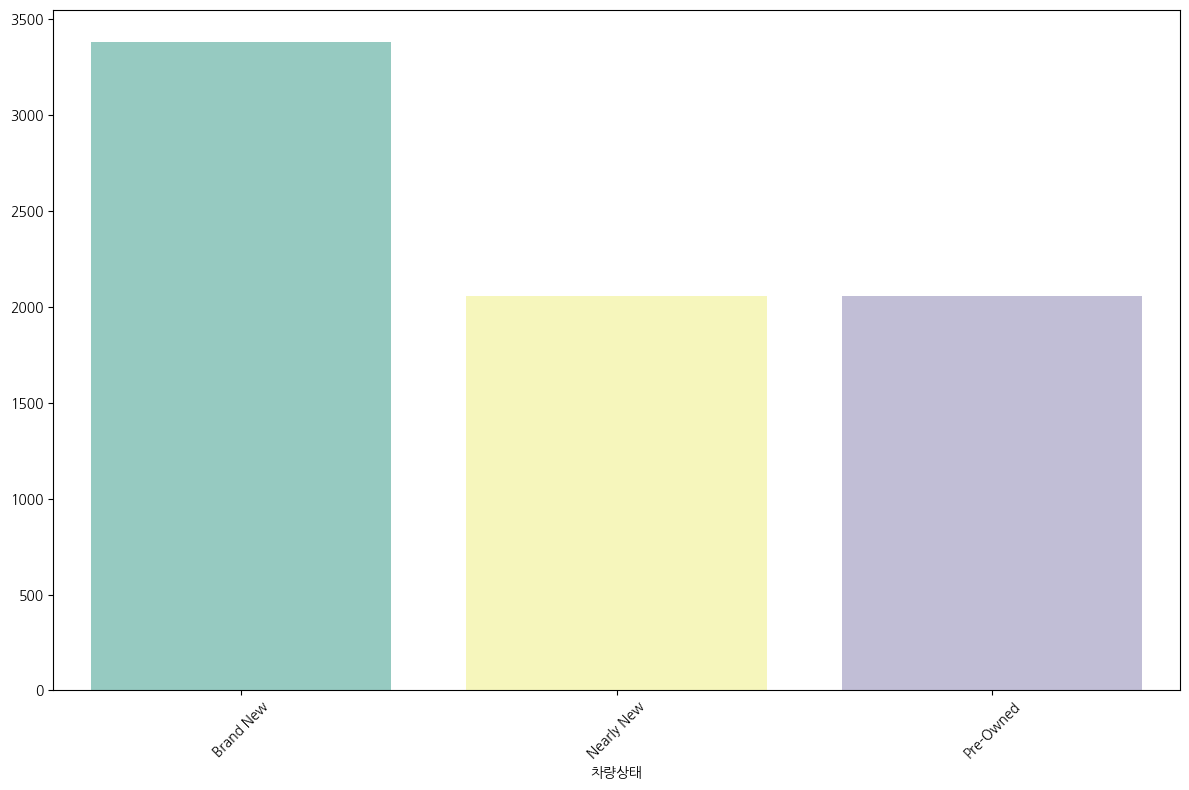

In [307]:
show_graph('차량상태')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



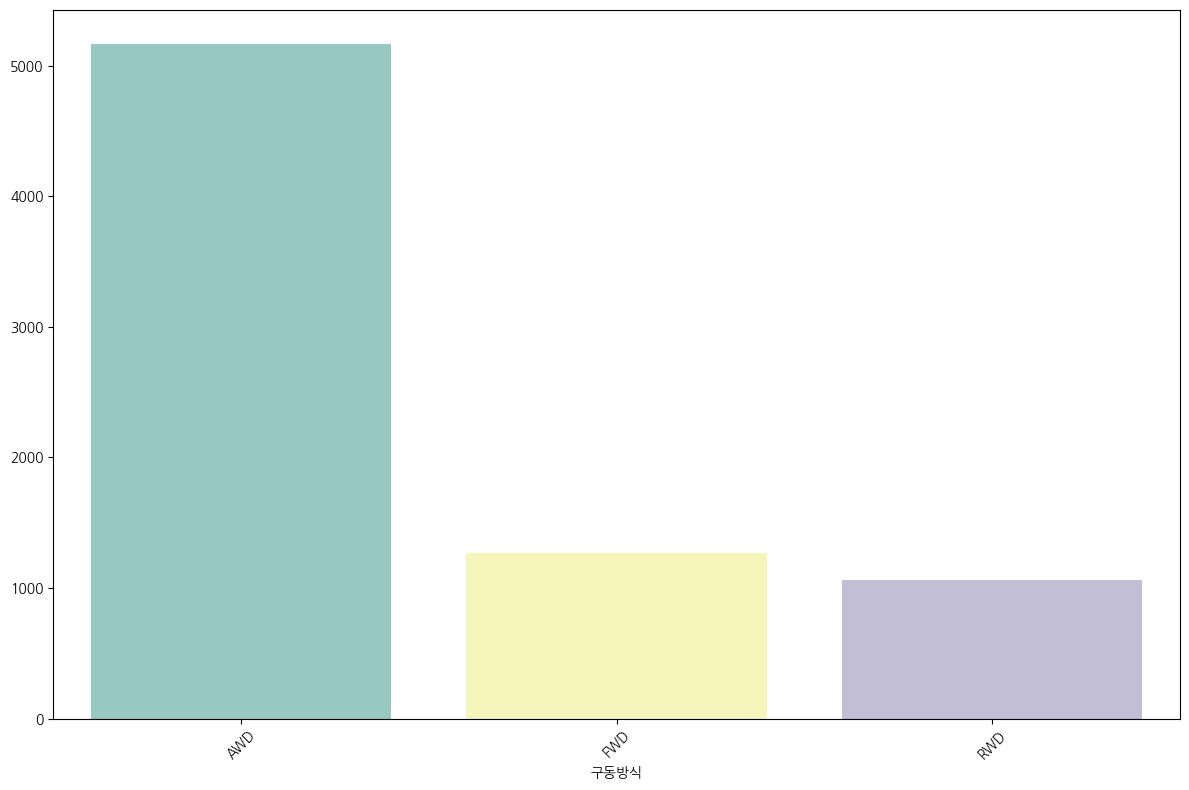

In [308]:
show_graph('구동방식')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



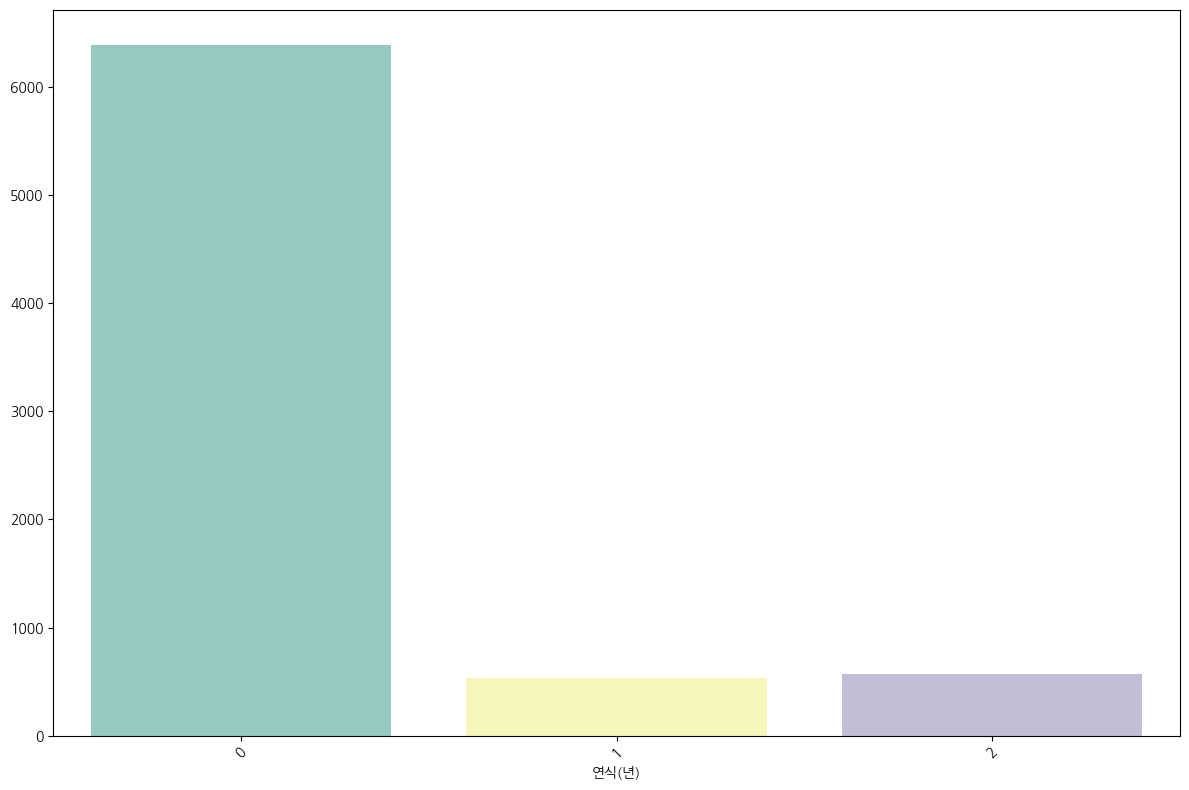

In [309]:
show_graph('연식(년)')

In [310]:
def print_mean_battery(col):
    for i in train_df[col].unique():
        print(f"{col} - {i} : {train_df[train_df[col] == i]['배터리용량'].mean()}")

In [311]:
print_mean_battery('연식(년)')

연식(년) - 2 : 69.538296
연식(년) - 0 : 69.68484126984127
연식(년) - 1 : 66.74253498871332


In [312]:
print_mean_battery('모델')

모델 - TayGTS : 80.45416988416989
모델 - Niro : 54.578933333333325
모델 - eT : 83.77656402439024
모델 - RSeTGT : 84.39925242718446
모델 - i5 : 65.49336119402984
모델 - ION6 : 65.87692340425532
모델 - MS : 89.67221266968326
모델 - MY : 63.91637988826815
모델 - Q4eT : 69.0407149122807
모델 - ID4 : 65.42444
모델 - TayCT : 77.5639326923077
모델 - Soul : 53.71446036585366
모델 - iX : 90.0
모델 - MX : 90.03115121951218
모델 - IONIQ : 62.04435185185184
모델 - EV6 : 90.0
모델 - KNE : 72.11759670781893
모델 - M3 : 64.48288165680474
모델 - i3 : 52.691131498470945
모델 - ION5 : 66.43954545454545
모델 - Tay : 67.16731555555556


In [313]:
print_mean_battery('보증기간(년)')

보증기간(년) - 0 : 59.936046931407944
보증기간(년) - 6 : 68.75179527559055
보증기간(년) - 7 : 83.86369625246549
보증기간(년) - 3 : 61.30074884792627
보증기간(년) - 1 : 59.83024901185771
보증기간(년) - 5 : 64.60444846796658
보증기간(년) - 8 : 84.68549800796812
보증기간(년) - 10 : 90.0
보증기간(년) - 2 : 68.24809410548086
보증기간(년) - 4 : 61.65939722222222
보증기간(년) - 9 : 90.0


In [314]:
print_mean_battery('차량상태')

차량상태 - Nearly New : 66.67888807649044
차량상태 - Brand New : 92.5865671641791
차량상태 - Pre-Owned : 59.053240185950415


In [315]:
print_mean_battery('제조사')

제조사 - P사 : 75.26528034682082
제조사 - K사 : 57.49066711590296
제조사 - A사 : 78.77559787556905
제조사 - B사 : 62.34454742547425
제조사 - H사 : 67.39844044665013
제조사 - T사 : 78.31083204134367
제조사 - V사 : 65.42444


In [316]:
train_df.groupby('연식(년)')['배터리용량'].mean()

연식(년)
0    69.684841
1    66.742535
2    69.538296
Name: 배터리용량, dtype: float64

In [317]:
train_df['주행거리'] = train_df['주행거리(km)'].apply(lambda x: 'new' if x <= 10000 else ('mid' if x <= 80000 else 'old'))
test_df['주행거리'] = test_df['주행거리(km)'].apply(lambda x: 'new' if x <= 10000 else ('mid' if x <= 80000 else 'old'))

In [318]:
def draw_mean_battery(col):
    fig, ax = plt.subplots(figsize = (12, 8))
    sns.barplot(x = sorted(train_df[col].unique()),
                y = train_df.groupby(col)['배터리용량'].mean(),
                palette = 'tab20c',
                ax = ax)
    plt.xticks(rotation = 45, size = 20)
    plt.yticks(size = 15)
    plt.title(f'{col} - 평균 배터리', size = 20)
    ax.set_ylabel('배터리 용량 (평균)', fontsize = 20)
    plt.tight_layout()
    plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



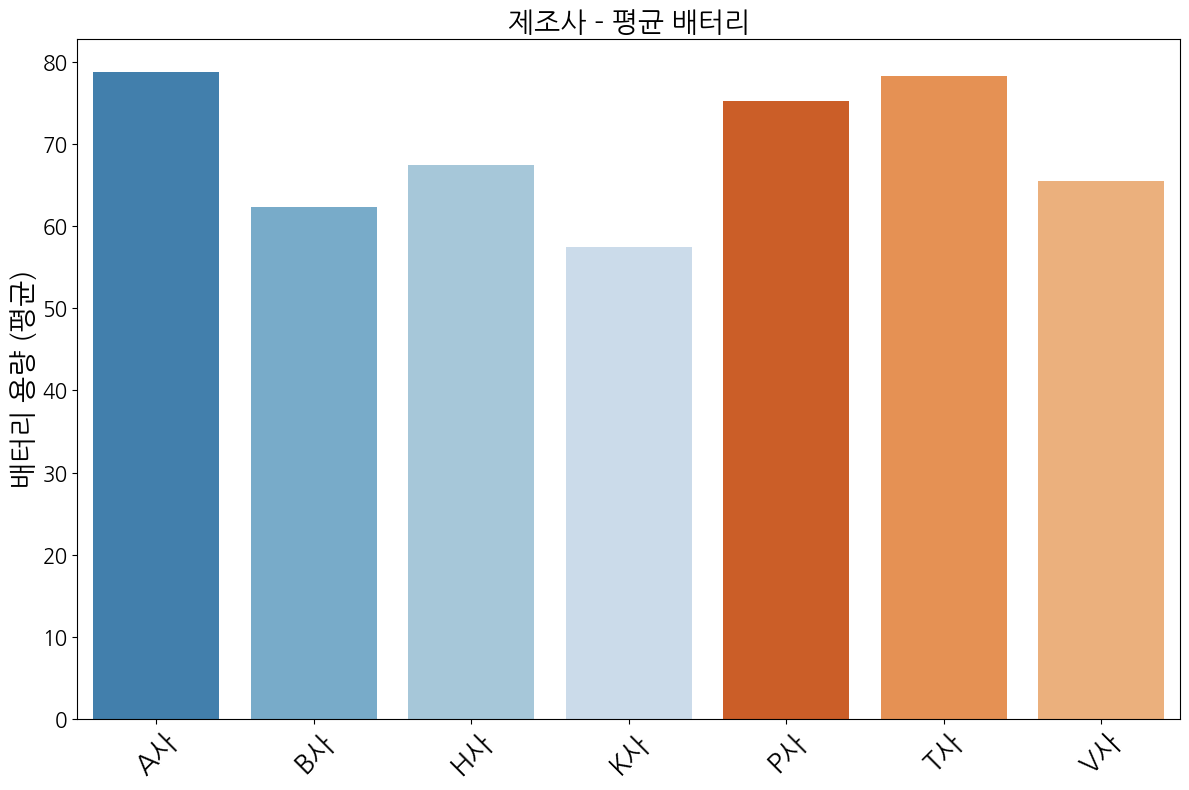

In [319]:
draw_mean_battery('제조사')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



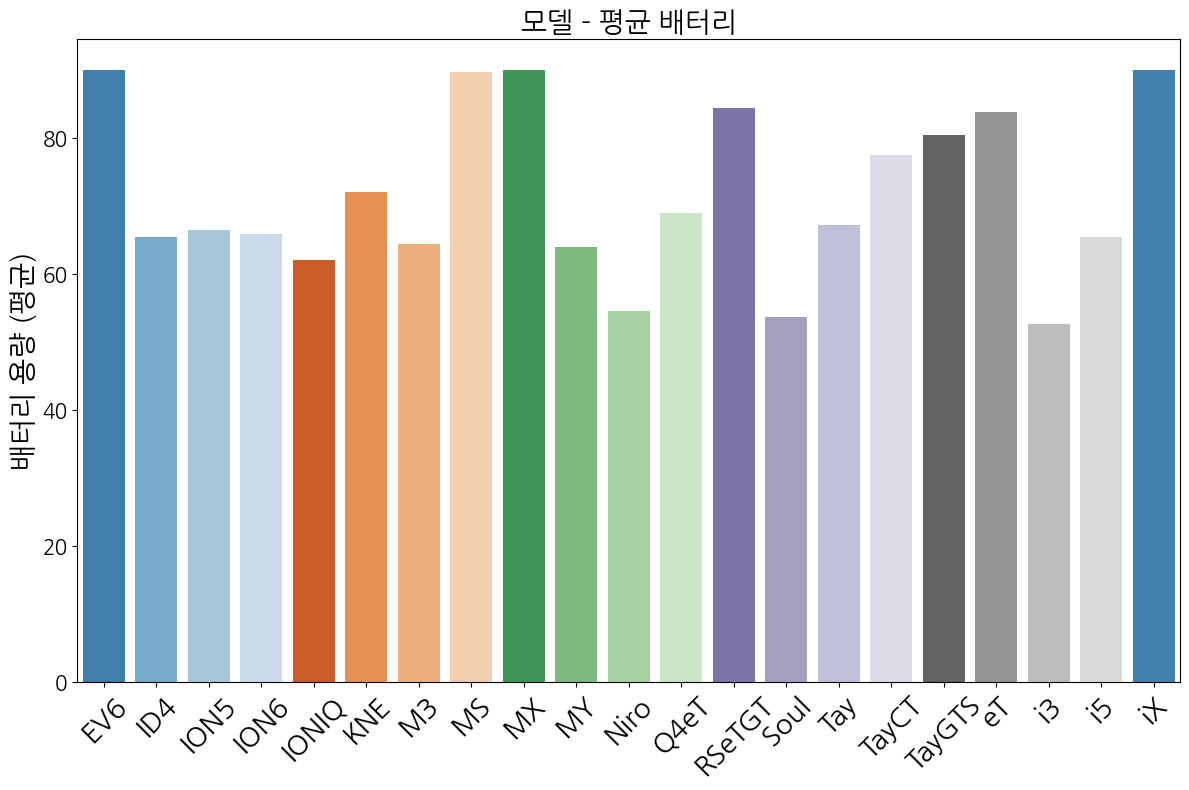

In [320]:
draw_mean_battery('모델')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



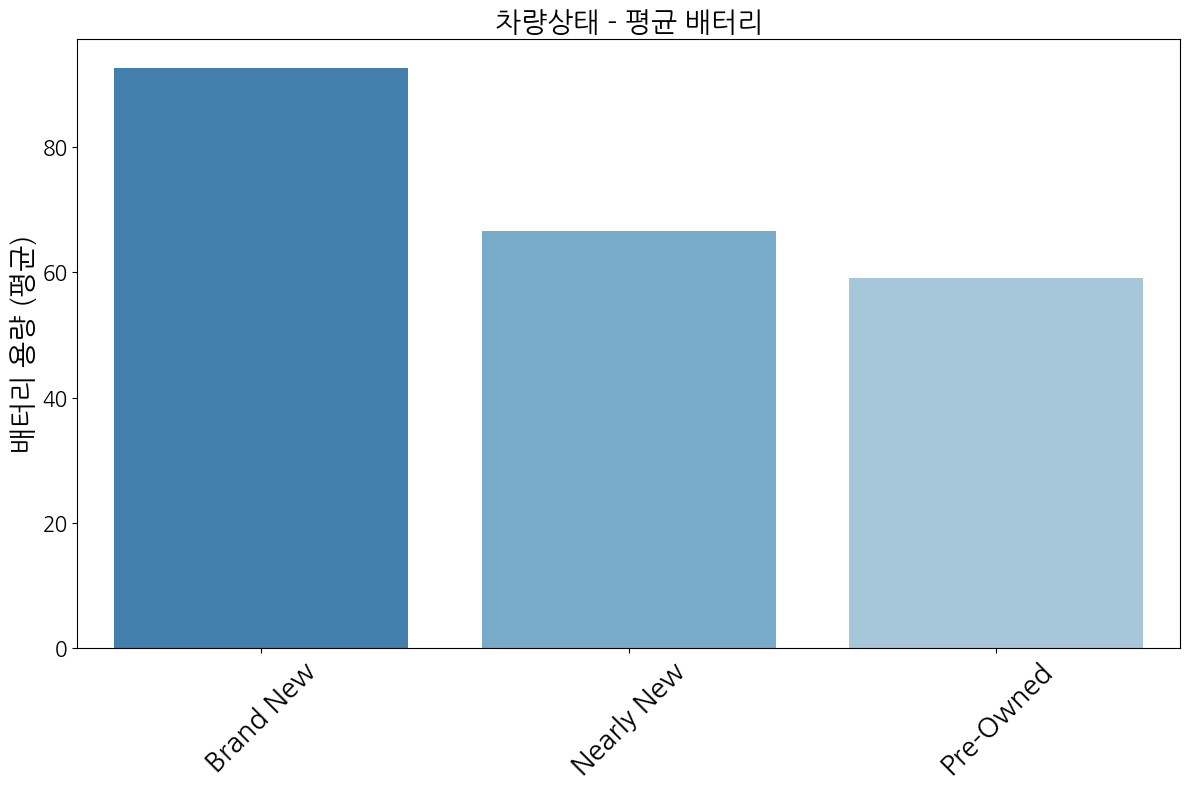

In [321]:
draw_mean_battery('차량상태')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



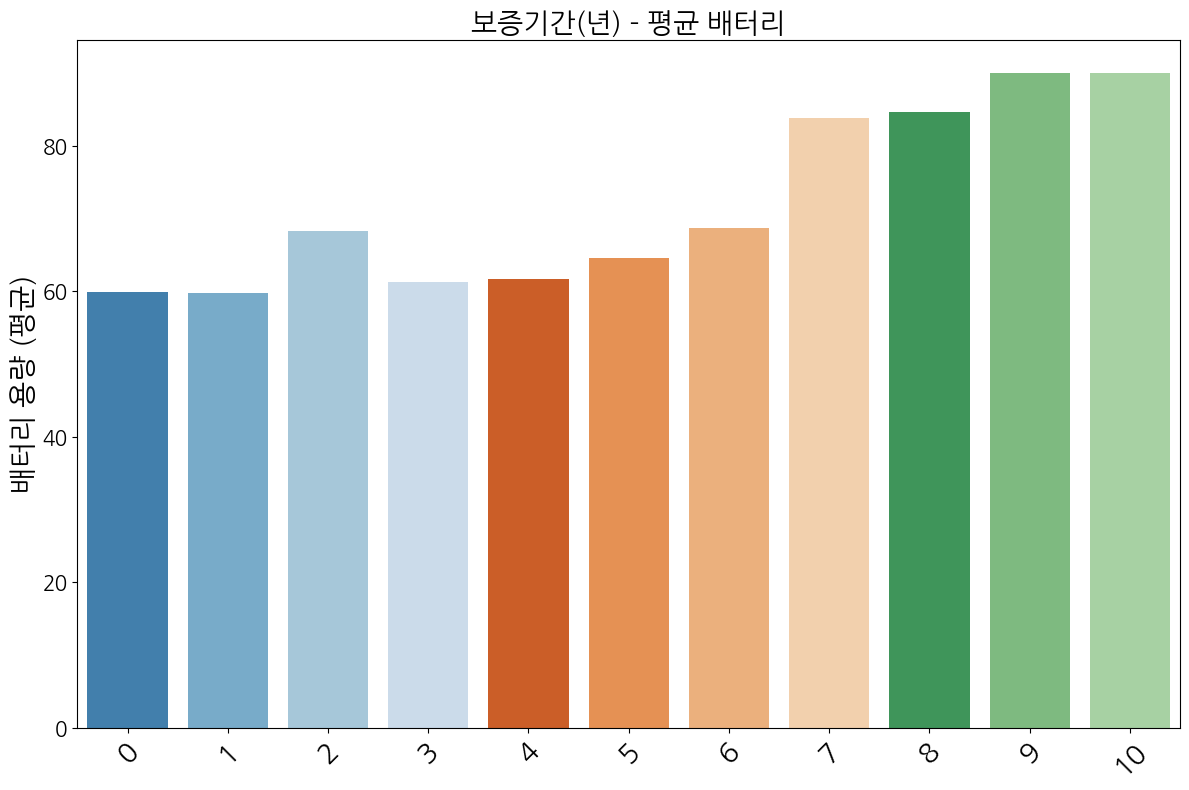

In [322]:
draw_mean_battery('보증기간(년)')

In [323]:
train_df.corr(numeric_only = True)

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.576538,0.558242,-0.021845,0.431668
주행거리(km),-0.576538,1.000000,-0.664071,-0.089586,-0.035488
보증기간(년),0.558242,-0.664071,1.000000,0.035294,-0.349962
연식(년),-0.021845,-0.089586,0.035294,1.000000,-0.058455
가격(백만원),0.431668,-0.035488,-0.349962,-0.058455,1.000000


모델, 보증기간 7년 이상, 차량 상태가 배터리 용량을 결정

In [324]:
train_df[train_df['배터리용량'].isna()]

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),주행거리
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16,mid
6,TRAIN_0006,T사,MS,Nearly New,NaN,AWD,19395,3,No,0,83.42,mid
8,TRAIN_0008,T사,MY,Brand New,NaN,AWD,2226,8,No,0,74.06,new
9,TRAIN_0009,A사,Q4eT,Brand New,NaN,AWD,3683,7,No,0,59.66,new
11,TRAIN_0011,V사,ID4,Brand New,NaN,AWD,1131,8,No,0,40.50,new
...,...,...,...,...,...,...,...,...,...,...,...,...
7489,TRAIN_7489,H사,ION5,Brand New,NaN,AWD,8871,9,No,0,35.83,new
7490,TRAIN_7490,A사,Q4eT,Brand New,NaN,AWD,5794,7,No,0,59.95,new
7491,TRAIN_7491,K사,Soul,Brand New,NaN,FWD,5966,10,No,0,16.75,new
7492,TRAIN_7492,H사,ION5,Brand New,NaN,AWD,3773,10,No,0,35.95,new


In [325]:
train_df['보증기간'] = train_df['보증기간(년)'].apply(lambda x: 'high' if x >= 7 else 'low')
test_df['보증기간'] = test_df['보증기간(년)'].apply(lambda x: 'high' if x >= 7 else 'low')

In [326]:
def fill_battery(cond_df, df):
    for i in range(len(cond_df)):
        model = cond_df.iloc[i]['모델']
        status = cond_df.iloc[i]['차량상태']
        warranty = cond_df.iloc[i]['보증기간']
        
        cond = (train_df['모델'] == model) & (train_df['차량상태'] == status) & (train_df['보증기간'] == warranty)       
        df.loc[cond_df.iloc[i].name, '배터리용량'] = train_df[cond]['배터리용량'].mean()

In [327]:
fill_battery(train_df[train_df['배터리용량'].isna()], train_df)
fill_battery(test_df[test_df['배터리용량'].isna()], test_df)

In [328]:
train_df

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),주행거리,보증기간
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66,mid,low
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01,mid,low
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27,new,high
3,TRAIN_0003,A사,RSeTGT,Nearly New,78.227,AWD,21683,3,No,0,99.16,mid,low
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02,old,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,90.000,AWD,3773,10,No,0,35.95,new,high
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40,old,low
7494,TRAIN_7494,P사,TayCT,Brand New,90.000,AWD,1363,2,No,0,120.00,new,low
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00,mid,low


In [329]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     7497 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
 11  주행거리      7497 non-null   object 
 12  보증기간      7497 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 761.5+ KB


In [330]:
test_df

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),주행거리,보증기간
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0,mid,low
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0,new,high
2,TEST_002,B사,i5,Brand New,90.000,RWD,7197,7,Yes,0,new,high
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1,mid,high
4,TEST_004,K사,EV6,Brand New,90.000,FWD,7597,10,No,0,new,high
...,...,...,...,...,...,...,...,...,...,...,...,...
841,TEST_841,P사,TayGTS,Pre-Owned,64.683,AWD,117298,2,No,0,old,low
842,TEST_842,V사,ID4,Pre-Owned,55.547,AWD,72308,0,No,0,mid,low
843,TEST_843,V사,ID4,Pre-Owned,55.547,AWD,124537,0,No,0,old,low
844,TEST_844,A사,Q4eT,Nearly New,69.646,AWD,15629,4,No,0,mid,low


In [331]:
def draw_mean_price(col):
    fig, ax = plt.subplots(figsize = (12, 8))
    sns.barplot(x = sorted(train_df[col].unique()),
                y = train_df.groupby(col)['가격(백만원)'].mean(),
                palette = 'tab20c',
                ax = ax)
    plt.xticks(rotation = 45, size = 20)
    plt.yticks(size = 15)
    plt.title(f'{col} - 평균 가격', size = 20)
    ax.set_ylabel('가격 (평균)', fontsize = 20)
    plt.tight_layout()
    plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



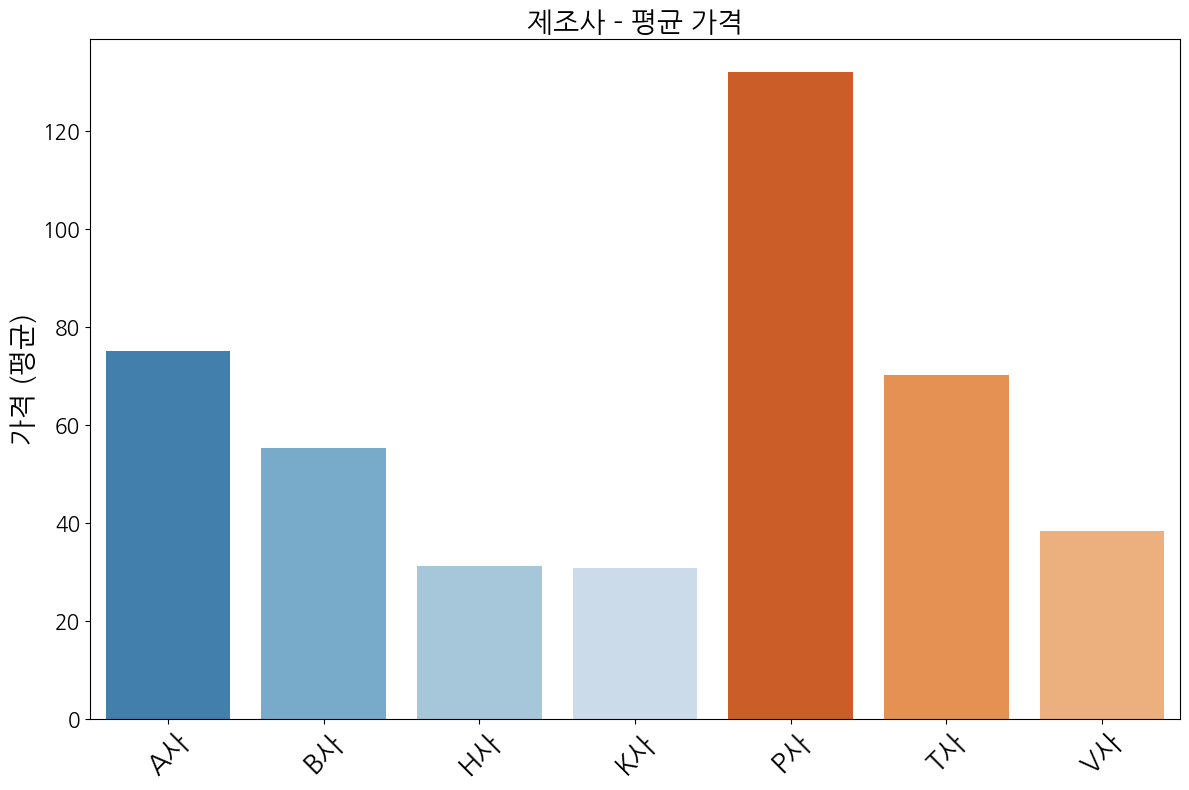

In [332]:
draw_mean_price('제조사')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



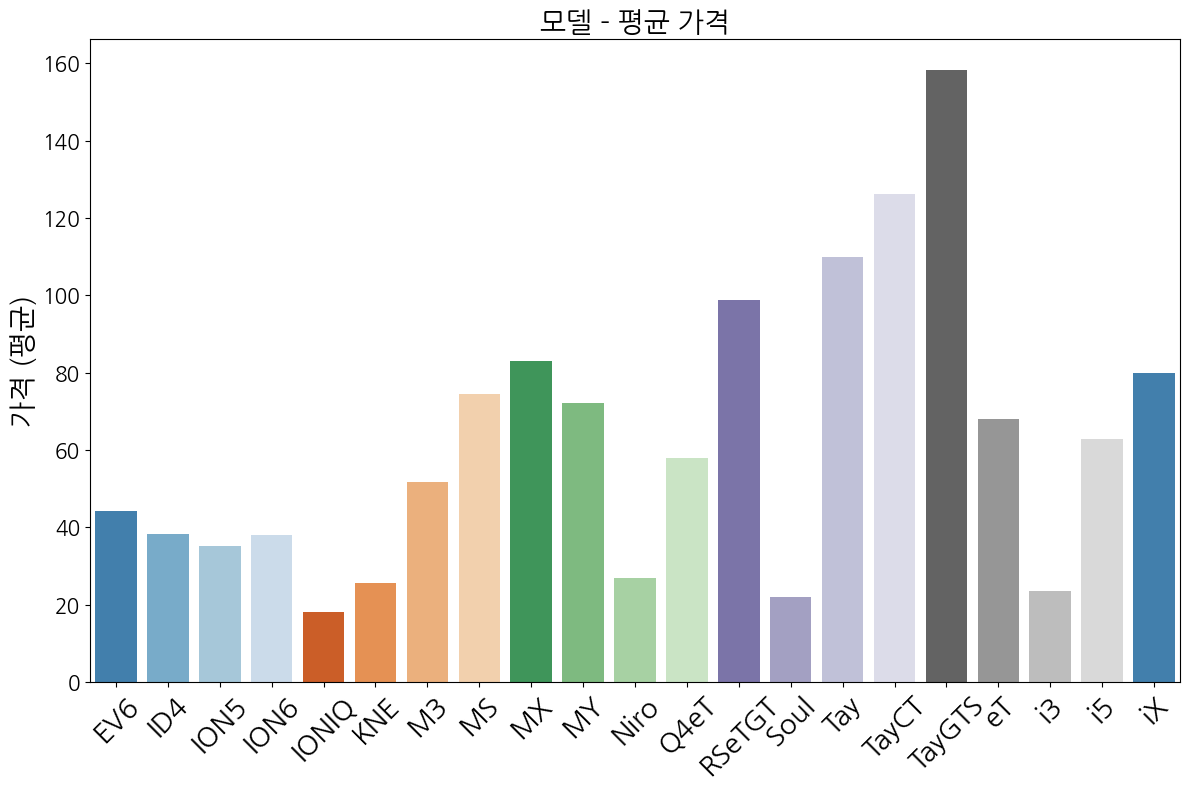

In [333]:
draw_mean_price('모델')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



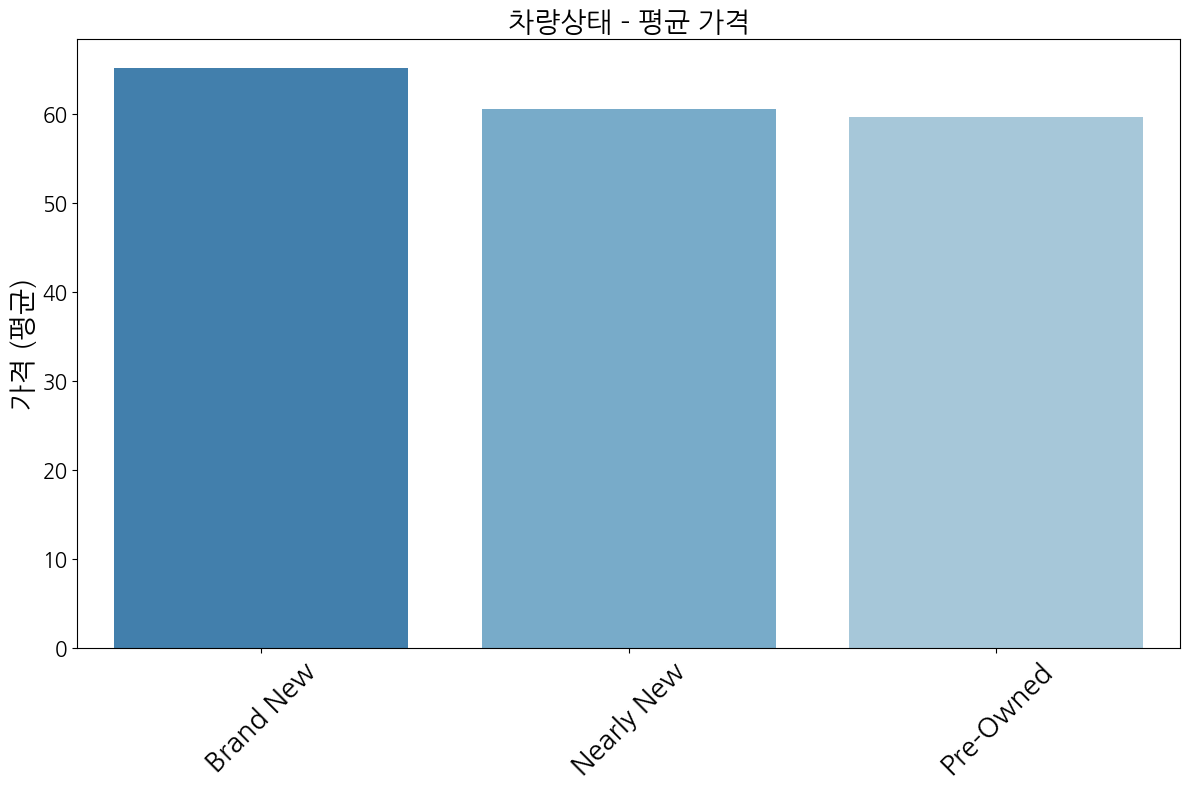

In [334]:
draw_mean_price('차량상태')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



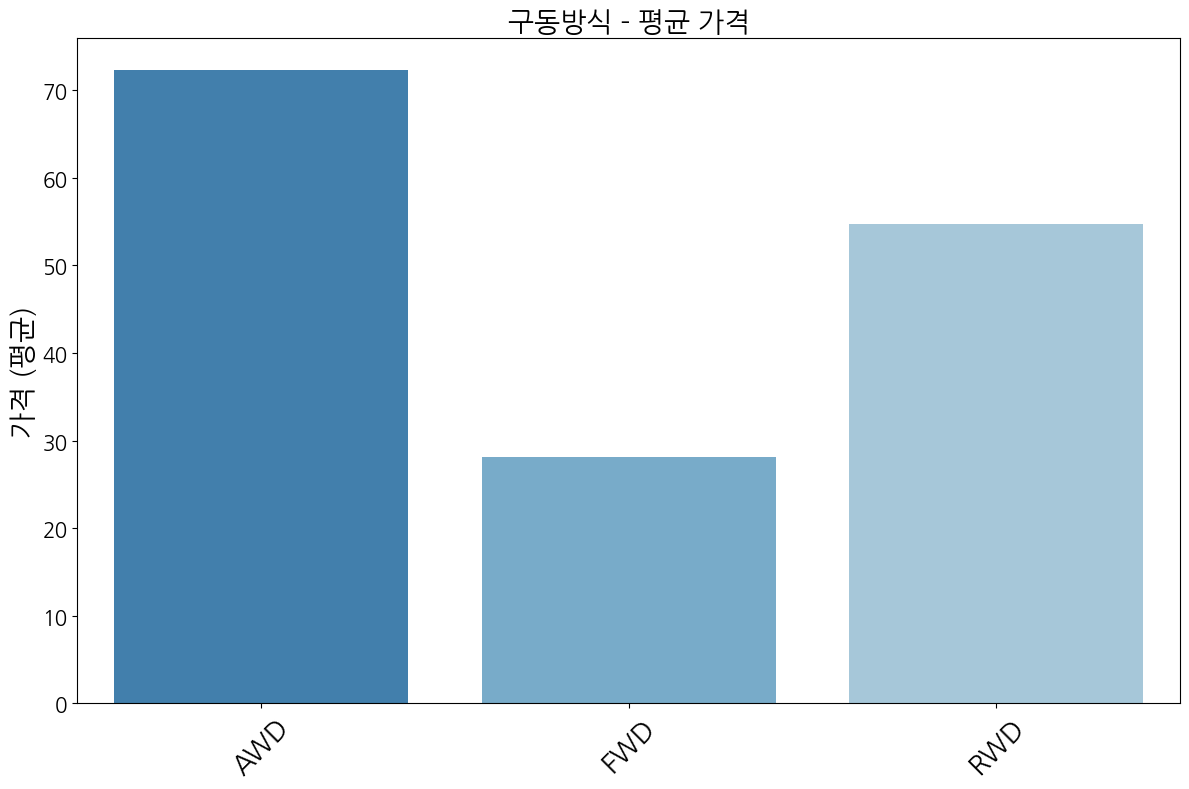

In [335]:
draw_mean_price('구동방식')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



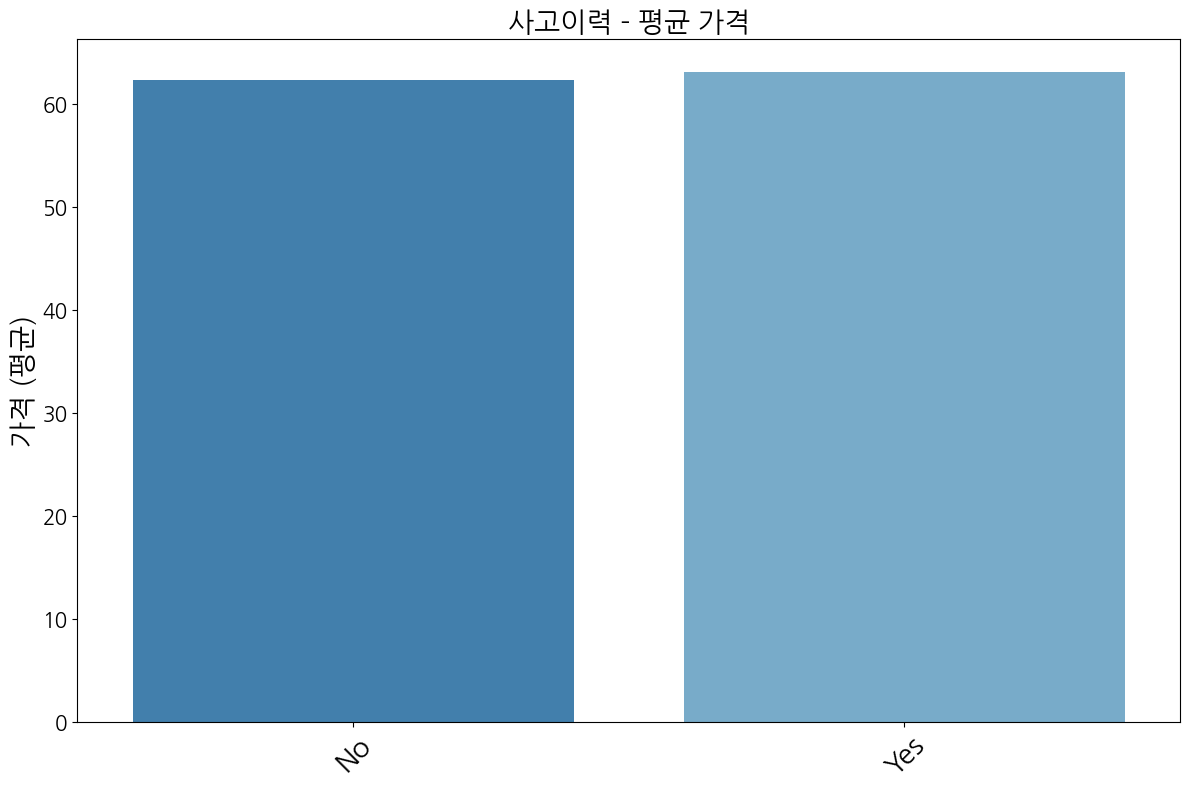

In [336]:
draw_mean_price('사고이력')

In [337]:
mean_prices = train_df.groupby('모델')['가격(백만원)'].mean()
train_df['모델_평균가격순위'] = train_df['모델'].map(mean_prices.rank(ascending = False))
test_df['모델_평균가격순위'] = test_df['모델'].map(mean_prices.rank(ascending = False))  # train 데이터 기반으로 rank 적용


In [338]:
mean_prices = train_df.groupby('제조사')['가격(백만원)'].mean()
train_df['제조사_평균가격순위'] = train_df['제조사'].map(mean_prices.rank(ascending = False))
test_df['제조사_평균가격순위'] = test_df['제조사'].map(mean_prices.rank(ascending = False))  # train 데이터 기반으로 rank 적용


In [339]:
object_list = ['제조사', '모델', '차량상태', '구동방식', '보증기간', '사고이력', '주행거리']

label_encoders = {}  # 각 열에 대한 LabelEncoder를 저장할 딕셔너리

# train_df와 test_df 모두에 대해 동일한 인코딩 적용
for col in object_list:
    le = LabelEncoder()
    le.fit(pd.concat([train_df[col], test_df[col]], axis=0))  # 두 데이터프레임의 모든 범주 고려
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    
    label_encoders[col] = le  # 나중에 디코딩할 수 있도록 저장


In [340]:
train_df.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),주행거리,보증기간,모델_평균가격순위,제조사_평균가격순위
0,TRAIN_0000,4,16,1,86.077,0,13642,0,0,2,159.66,0,1,1.0,1.0
1,TRAIN_0001,3,10,1,56.000,1,10199,6,0,0,28.01,0,1,17.0,7.0
2,TRAIN_0002,0,17,0,91.200,0,2361,7,0,0,66.27,1,0,9.0,2.0
3,TRAIN_0003,0,12,1,78.227,0,21683,3,0,0,99.16,0,1,4.0,2.0
4,TRAIN_0004,1,19,2,61.018,0,178205,1,0,0,62.02,2,1,10.0,4.0


In [341]:
test_df.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),주행거리,보증기간,모델_평균가격순위,제조사_평균가격순위
0,TEST_000,4,15,1,76.093,0,14057,2,0,0,0,1,2.0,1.0
1,TEST_001,1,20,0,90.000,0,7547,8,0,0,1,0,6.0,4.0
2,TEST_002,1,19,0,90.000,2,7197,7,1,0,1,0,10.0,4.0
3,TEST_003,2,2,1,68.479,0,10357,7,0,1,0,0,16.0,6.0
4,TEST_004,3,0,0,90.000,1,7597,10,0,0,1,0,13.0,7.0


In [342]:
train_df.drop('ID', axis = 1, inplace = True)
test_df.drop('ID', axis = 1, inplace = True)

In [343]:
target = train_df[['가격(백만원)']].astype(float)
feature = train_df.drop(['가격(백만원)', '주행거리(km)', '구동방식', '주행거리', '사고이력'], axis = 1)

In [344]:
test_df.drop(['주행거리(km)', '구동방식', '주행거리', '사고이력'], axis = 1, inplace = True)

In [345]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   가격(백만원)  7497 non-null   float64
dtypes: float64(1)
memory usage: 58.7 KB


In [346]:
# X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2, random_state = 42)

dtrain = lgb.Dataset(feature, target)
dtest = lgb.Dataset(test_df)

In [347]:
dtrain

In [348]:
def objective(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 10, 50),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.001, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "verbosity": -1,
        "num_threads": -1
    }

    # LightGBM dataset 생성
    train_data = lgb.Dataset(feature, label=target)
    num_boost_round = trial.suggest_int('num_boost_round', 100, 1000)

    # lgb.cv 실행 (교차검증)
    cv_results = lgb.cv(
        param,
        train_data,
        num_boost_round = num_boost_round,
        nfold = 10, 
        stratified = False, 

    )


    # 교차 검증 결과의 RMSE 평균 반환
    mean_rmse = np.mean(cv_results['valid rmse-mean'])
    return mean_rmse

In [349]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 1000, show_progress_bar = True)

# 최적 하이퍼파라미터 출력
print("Best hyperparameters:", study.best_params)

# 최적 하이퍼파라미터로 최종 모델 학습
best_param = study.best_params




Best trial: 2. Best value: 1.43539:   0%|          | 5/1000 [00:20<1:07:01,  4.04s/it]


[W 2025-01-18 16:49:15,304] Trial 5 failed with parameters: {'learning_rate': 0.009473584876918732, 'num_leaves': 37, 'max_depth': 15, 'min_child_weight': 2.894645819916076, 'subsample': 0.6300153163250557, 'colsample_bytree': 0.5484057050043605, 'lambda_l1': 3.834584185665495, 'lambda_l2': 9.53116597261454, 'num_boost_round': 553} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\PNC\anaconda3\envs\Project_38\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\PNC\AppData\Local\Temp\ipykernel_14228\2991488753.py", line 23, in objective
    cv_results = lgb.cv(
  File "c:\Users\PNC\anaconda3\envs\Project_38\lib\site-packages\lightgbm\engine.py", line 826, in cv
    cvfolds.update(fobj=fobj)  # type: ignore[call-arg]
  File "c:\Users\PNC\anaconda3\envs\Project_38\lib\site-packages\lightgbm\engine.py", line 402, in handler_function
    ret.append(getattr(booster, na

KeyboardInterrupt: 

In [ ]:
final_model = lgb.train(
    params = best_param,
    train_set = dtrain,
    num_boost_round = best_param['num_boost_round'],
)

# 예측 및 평가
y_pred = final_model.predict(test_df)

c:\Users\PNC\anaconda3\envs\Project_38\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(test_df)

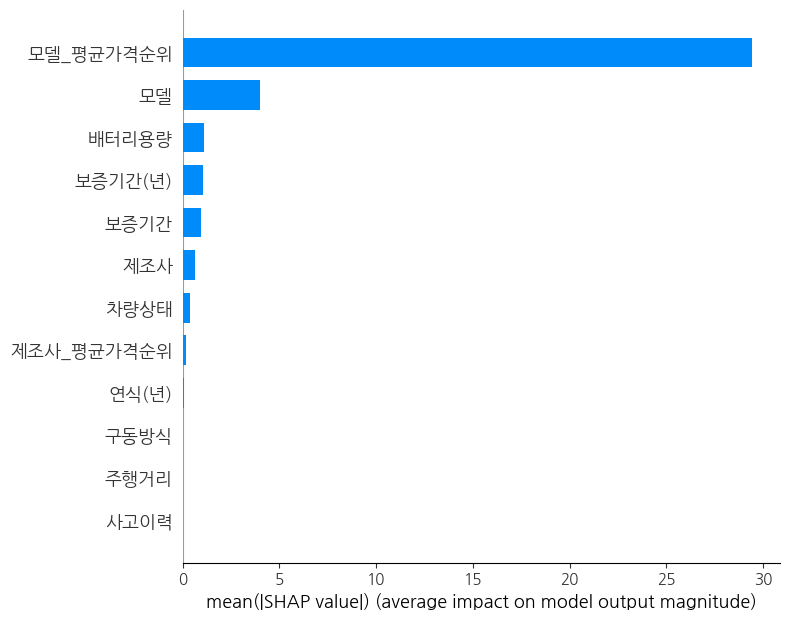

In [ ]:
shap.summary_plot(shap_values, test_df, plot_type="bar")

In [248]:
print(y_pred)

submission_df['가격(백만원)'] = y_pred

submission_df.to_csv(DATA_PATH + 'lgb_submission.csv', index = False)

[130.77342252  80.01271126  64.92211184  34.82533015  47.92138408
  99.75065896  21.76658405  40.01766117  81.33065801  24.66320228
  63.78711828  62.5786105   40.26328784 100.26796861  90.43934841
  22.82256461 126.2716028   52.78406575  60.01470071  34.7059065
  37.73720093 159.95523087  46.84875755  55.89700081  23.14934844
  47.92138408  78.74468512  79.99128642  27.95955102 126.71138321
  63.78711828  40.87089591 114.67396312  88.2876552   35.65103072
  80.03963046  21.67245151  40.01766117  24.64003131 120.99321247
 125.77209442  18.32538635 119.45843488  60.65162038  23.14934844
 100.26796861  21.67245151  74.158291    62.61291529  78.14392056
  35.68863933  17.37962201  38.79876048 126.2716028   23.76169703
  27.87409808 156.08367758  41.02684901 160.27091152  40.26328784
  55.89700081 125.77209442  40.79390387 120.88239646  40.053235
  33.76794842  72.32634941  50.13796963 100.26796861  22.95712955
  47.92138408  27.92883689  64.24701066  38.79876048 125.77209442
  23.20667401